## STEP 4: DEVELOP A FUZZY LOGIC MODEL

A fuzzy logic model is one that is built on expert knowledge rather than
training data. You may wish to use the
[`scikit-fuzzy`](https://pythonhosted.org/scikit-fuzzy/) library, which
includes many utilities for building this sort of model. In particular,
it contains a number of **membership functions** which can convert your
data into values from 0 to 1 using information such as, for example, the
maximum, minimum, and optimal values for soil pH.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>To train a fuzzy logic habitat suitability model:</p>
<pre><code>1. Research S. nutans, and find out what optimal values are for each variable you are using (e.g. soil pH, slope, and current climatological annual precipitation). 
2. For each **digital number** in each raster, assign a **continuous** value from 0 to 1 for how close that grid square is to the optimum range (1=optimal, 0=incompatible). 
3. Combine your layers by multiplying them together. This will give you a single suitability number for each square.
4. Optionally, you may apply a suitability threshold to make the most suitable areas pop on your map.</code></pre></div></div>

> **Tip**
>
> If you use mathematical operators on a raster in Python, it will
> automatically perform the operation for every number in the raster.
> This type of operation is known as a **vectorized** function. **DO NOT
> DO THIS WITH A LOOP!**. A vectorized function that operates on the
> whole array at once will be much easier and faster.

<span style='color: purple'>

Optimal and tolerable ranges:

* Soil:
    * Optimal pH: 6.5
    * Tolerable range: 5.0 - 7.5
    * *Source:* https://www.fs.usda.gov/psw/publications/documents/psw_rp028/psw_rp028.pdf

* Elevation:
    * Optimal: 100 ft - 2,500 ft
    * Tolerable range: sealevel - 3,000 ft
    * *Source for both ranges:* https://www.fs.usda.gov/psw/publications/documents/psw_rp028/psw_rp028.pdf

* Average annual precipitation:
    * Optimal: 50 in - 70 in (1270 mm - 1800 mm)
        * It was difficult to find a description of an exact optimal range of precipitation for the coastal redwood, so I am using the mean precipitation values from two different sources. The 50 inch number is from [here](https://www.nps.gov/parkhistory/online_books/shirley/sec4.htm#:~:text=The%20main%20part%20of%20the,100%20inches%20of%20rainfall%20annually.) and the 70 inch number is from [here](https://www.fs.usda.gov/database/feis/plants/tree/seqsem/all.html#11). 
    * Tolerable range: [20 in - 200 in (508 mm - 5080 mm)](https://plants.usda.gov/plant-profile/SESE3/characteristics)
</span>

<span style='color: purple'>

Load in stored variables:

</span>

In [1]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf
%store -r siskiyou_soil_ph_da padres_soil_ph_da
%store -r siskiyou_srtm_da padres_srtm_da
%store -r ave_annual_pr_das_list climate_df_list
%store -r siskiyou_elev_reproj_da padres_elev_reproj_da reproj_ave_annual_pr_das

<span style='color: purple'>

Import packages:

</span>

In [2]:
import cartopy.crs as ccrs
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import numpy as np
import rioxarray as rxr
import rioxarray.merge as rxrmerg
import skfuzzy as fuzz # Create fuzzy logic model
from tqdm.notebook import tqdm # Progress bars on loops
import xarray as xr

<span style='color:purple'>

## First look at suitability using boolean logic:

</span>

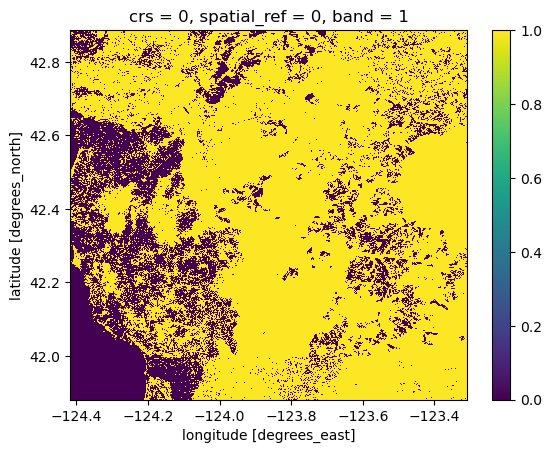

In [3]:
# use 'bitwise and' to see suitability of min and max precip values together
precip_suit = ((reproj_ave_annual_pr_das[0] > 508) & (reproj_ave_annual_pr_das[0] < 5080))

# use 'bitwise and' to see suitability of min and max pH values together
ph_suit = ((siskiyou_soil_ph_da > 5.0) & (siskiyou_soil_ph_da < 7.5))

# find suitability of precipitation and ph together
# this multiplies together each value of each suitability plot together
(precip_suit * ph_suit).plot()

<span style='color:purple'>

## Now look at suitability using fuzzy logic:

Going to use the trapezoidal membership function so that our optimal values have a range and or tolerable values have a range

</span>

<span style='color:purple'>

None of the values in the siskiyou_soil_ph_da are exactly 6.5, and I know that redwoods currently live in siskiyou, so instead of using a triangular membership function w/ one optimum value, we'll use a trapezoidal membership function and a range around 6.5.

First use trapezoidal membership function on soil_ph_das:
</span>

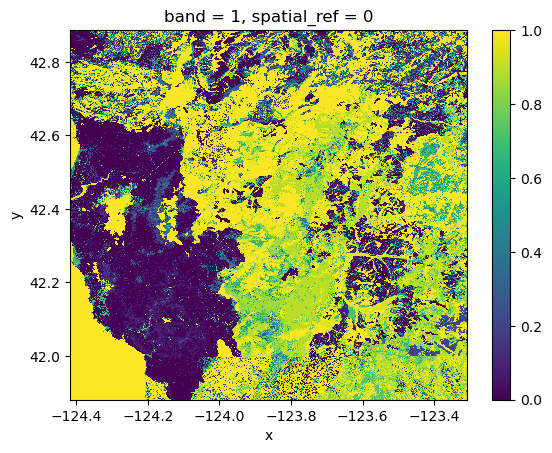

In [5]:
# save shape of siskiyou_soil_ph_da
shape = (siskiyou_soil_ph_da
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy siskiyou_soil_ph_da to keep all coordinates, etc
siskiyou_ph_fuzz = siskiyou_soil_ph_da.copy()

# create membership function
siskiyou_ph_fuzz.values = (
    # reshape 1D array created below back to siskiyou_soil_ph_da shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            siskiyou_soil_ph_da.values.flatten(),
            # pH tolerance and optimum values
            [5.0, 6.0, 7.0, 7.5]),
            shape
            )
        )
siskiyou_ph_fuzz.plot()

<span style='color:purple'>

Next use trapezoidal membership function on Siskiyou projected average annual precipitation in the 2050 time period for the CanESM2 model, reproj_ave_annual_pr_das[0].

</span>

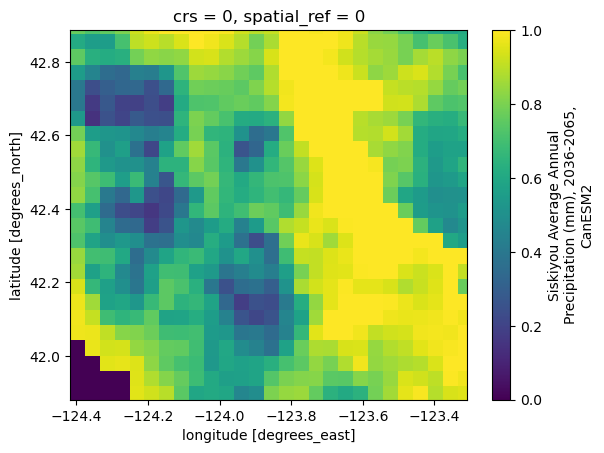

In [ ]:
# save shape of reproj_ave_annual_pr_das[0]
siskiyou_pr_2050_CanESM2_shape = (reproj_ave_annual_pr_das[0]
         # .values leaves just an array, removes the xarray wrappers
         .values
         .shape)

# copy reproj_ave_annual_pr_das[0] to keep all coordinates, etc
siskiyou_pr_2050_CanESM2_fuzz = reproj_ave_annual_pr_das[0].copy()

# create membership function
siskiyou_pr_2050_CanESM2_fuzz.values = (
    # reshape 1D array created below back to reproj_ave_annual_pr_das[0] shape
    np.reshape(
        fuzz.trapmf(
            # .flatten lays 2D array into 1D array
            reproj_ave_annual_pr_das[0].values.flatten(),
            # precip tolerance and optimum values
            [508, 1270, 1800, 5080]),
            siskiyou_pr_2050_CanESM2_shape
            )
        )
siskiyou_pr_2050_CanESM2_fuzz.plot()

<span style='color:purple'>

Now do raster multiplication w/ siskiyou_ph_fuzz and siskiyou_pr_2050_CanESM2_fuzz (we may be able to do this with skfuzzy.fuzzy_mult() or another scikit fuzzy multiplication function, using normal multiplication for now):

</span>

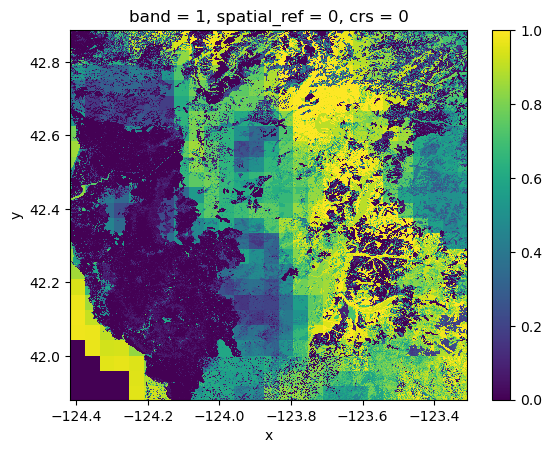

In [ ]:
# we could add robust=True inside the plot parentheses to make plot areas easier to see
(siskiyou_ph_fuzz * siskiyou_pr_2050_CanESM2_fuzz).plot()

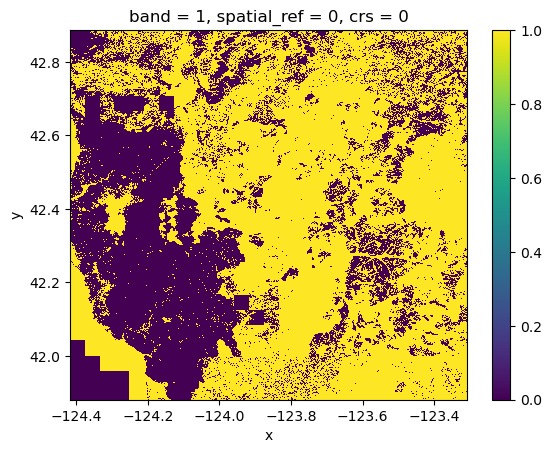

In [9]:
# set suitability threshold, change back to boolean logic
# for the ph and precip in the raster mult to be considered a suitabile habitat, their product has to be greater than .2
((siskiyou_ph_fuzz * siskiyou_pr_2050_CanESM2_fuzz) > .2).plot()

possible next step: use raster subtraction to subtract habitat suitability fuzzy logic models from the different time periods to see how much habitat suitability changes over time

<span style='color:purple'>

## Habitat suitability Fuzzy Logic for all climate model situations

Going to use the trapezoidal membership function so that our optimal values have a range and our tolerable values have a range

1. Create fuzzy models for each DataArray

    a. Add names to soil and elevation DataArrays

    b. Create a list of all DataArrays to loop through

    c. Make & use a function to create fuzzy models

2. Complete raster multiplication:

    a. Siskiyou pH fuzzy model * Siskiyou elevation fuzzy model * each of the four Siskiyou 2050 climate fuzzy models

    b. Siskiyou pH fuzzy model * Siskiyou elevation fuzzy model * each of the four Siskiyou 2080 climate fuzzy models
    
    c. Padres pH fuzzy model * Padres elevation fuzzy model * each of the four Padres 2050 climate fuzzy models

    d. Padres pH fuzzy model * Padres elevation fuzzy model * each of the four Padres 2080 climate fuzzy models

</span>

<span style='color:purple'>

1a. Add names to soil and elevation DataArrays:

</span>

In [3]:
siskiyou_soil_ph_da.name = 'Siskiyou Soil pH'
siskiyou_elev_reproj_da.name = 'Siskiyou Elevation (m)'
padres_soil_ph_da.name = 'Los Padres Soil pH'
padres_elev_reproj_da.name = 'Los Padres Elevation (m)'

<span style='color:purple'>

1b. Create a list of all DataArrays to loop through:

</span>

In [4]:
das_list = [
    siskiyou_soil_ph_da,
    siskiyou_elev_reproj_da,
    padres_soil_ph_da,
    padres_elev_reproj_da,
    reproj_ave_annual_pr_das[0],
    reproj_ave_annual_pr_das[1],
    reproj_ave_annual_pr_das[2],
    reproj_ave_annual_pr_das[3],
    reproj_ave_annual_pr_das[4],
    reproj_ave_annual_pr_das[5],
    reproj_ave_annual_pr_das[6],
    reproj_ave_annual_pr_das[7],
    reproj_ave_annual_pr_das[8],
    reproj_ave_annual_pr_das[9],
    reproj_ave_annual_pr_das[10],
    reproj_ave_annual_pr_das[11],
    reproj_ave_annual_pr_das[12],
    reproj_ave_annual_pr_das[13],
    reproj_ave_annual_pr_das[14],
    reproj_ave_annual_pr_das[15]
    ]

<span style='color:purple'>

1c. Create function to use trapezoidal membership function on each DataArray:

</span>

In [5]:
def create_trapmf(da,
                  tol_min,
                  opt_min,
                  opt_max,
                  tol_max
                  ):
    """
    Use the sci-kit fuzzy trapezoidal membership function generator
    to put the values of a DataArray into a trapezoidal membership function.

    Parameters
    ----------
    da : DataArray
        The DataArray a trapezoidal membership function is being created for
    tol_min : int or float
        the minimum value of the tolerance range of the variable
    opt_min : int or float
        the minimum value of the optimum range of the variable
    opt_max : int or float
        the maximum value of the optimum range of the variable
    tol_max : int or float
        the maximum value of the tolerange range of the variable

    Returns
    -------
    fuzz_da : DataArray
        A DataArray with the shape and coordinates of the
        `da` but values created by the sci-kit fuzzy
        trapezoidal membership function generator
    """
    # save the shape of the DataArray
    da_shape = (da
                # .values leaves just an array, removes the xarray wrappers
                .values
                .shape)

    # copy DataArray to keep all coordinates, etc
    fuzz_da = da.copy()

    # create membership function
    fuzz_da.values = (
        # reshape 1D array created below back to da_shape
        np.reshape(
            fuzz.trapmf(
                # .flatten lays 2D array into 1D array
                da.values.flatten(),
                # variable tolerance and optimum values
                [tol_min, opt_min, opt_max, tol_max]),
                da_shape
                )
        )
    
    # name the fuzz_da based on the name of the DataArray parameter
    fuzz_da.name = f'{da.name} Fuzzy'
    return fuzz_da

In [6]:
# empty list for fuzzy DataArrays
fuzz_das_list = []

# for each DataArray in the das_list,
for i in tqdm(das_list):
    # if it is a soil DataArray,
    if 'Soil' in i.name:
        # use the create_trapmf fxn w/ pH optimum/tolerance values
        soil_fuzz_da = create_trapmf(i, 5.0, 6.0, 7.0, 7.5)
        fuzz_das_list.append(soil_fuzz_da)
    # if it is an elevation DataArray,
    if 'Elevation' in i.name:
        # use the create_trapmf fxn w/ elev optimum/tolerance values
        elev_fuzz_da = create_trapmf(i, 0, 100, 2500, 3000)
        fuzz_das_list.append(elev_fuzz_da)
    # if it is a precipitation DataArray,
    if 'Precipitation' in i.name:
        # use the create_trapmf fxn w/ precip optimum/tolerance values
        pr_fuzz_da = create_trapmf(i, 508, 1270, 1800, 5080)
        fuzz_das_list.append(pr_fuzz_da)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
# check fuzz_das_list
fuzz_das_list

[<xarray.DataArray 'Siskiyou Soil pH Fuzzy' (y: 3622, x: 3989)> Size: 116MB
 array([[0.        , 0.        , 0.        , ..., 1.        , 1.        ,
         1.        ],
        [0.        , 0.06438589, 0.06510162, ..., 1.        , 0.95626163,
         1.        ],
        [0.        , 0.        , 0.        , ..., 0.97916555, 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 0.95698071, 0.98429823,
         1.        ],
        [1.        , 1.        , 1.        , ..., 0.97370338, 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 0.97861862, 0.98726034,
         1.        ]])
 Coordinates:
   * x            (x) float64 32kB -124.4 -124.4 -124.4 ... -123.3 -123.3 -123.3
   * y            (y) float64 29kB 42.89 42.89 42.89 42.89 ... 41.88 41.88 41.88
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     nan,
 <xarray.DataArray 'Siskiyou Elevat

<span style='color:purple'>

## Next, do raster multiplication:

</span>

In [8]:
# multiply Siskiyou Soil pH Fuzzy,
# Siskiyou Elevation (m) Fuzzy, and
# Siskiyou Ave Annual Precip 2036-2065 climate models
s_2050_can = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[4]
s_2050_miroc = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[5]
s_2050_mri = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[6]
s_2050_gfdl = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[7]

In [9]:
# multiply Siskiyou Soil pH Fuzzy,
# Siskiyou Elevation (m) Fuzzy, and
# Siskiyou Ave Annual Precip 2066-2095 climate models
s_2080_can = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[8]
s_2080_miroc = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[9]
s_2080_mri = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[10]
s_2080_gfdl = fuzz_das_list[0] * fuzz_das_list[1] * fuzz_das_list[11]

In [10]:
# multiply Padres Soil pH Fuzzy,
# Padres Elevation (m) Fuzzy, and
# Padres Ave Annual Precip 2036-2065 climate models
p_2050_can = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[12]
p_2050_miroc = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[13]
p_2050_mri = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[14]
p_2050_gfdl = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[15]

In [11]:
# multiply Padres Soil pH Fuzzy,
# Padres Elevation (m) Fuzzy, and
# Padres Ave Annual Precip 2066-2095 climate models
p_2080_can = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[16]
p_2080_miroc = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[17]
p_2080_mri = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[18]
p_2080_gfdl = fuzz_das_list[2] * fuzz_das_list[3] * fuzz_das_list[19]

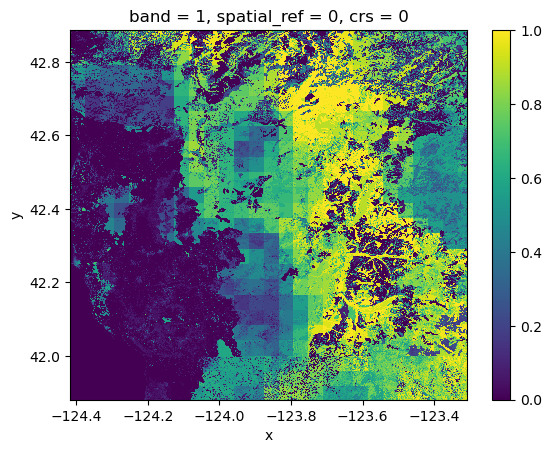

In [12]:
s_2050_can.plot()

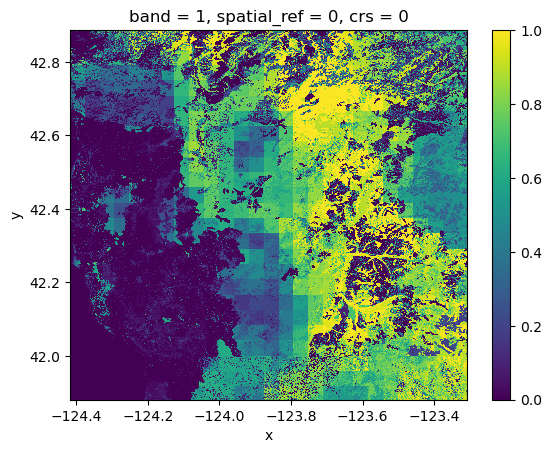

In [13]:
s_2080_can.plot()

In [22]:
s_2050_can_suit = (s_2050_can > .5)

In [25]:
s_2080_can_suit = s_2080_can > .5

used chatgpt to write this code:

In [23]:
# Calculate the percentage of 1's in the DataArray
percent_ones = (s_2050_can_suit == 1).sum() / s_2050_can_suit.size * 100

print(f"Percentage of 1's: {percent_ones.values}%")

Percentage of 1's: 42.59484150159488%


In [28]:
# Calculate the percentage of 1's in the DataArray
percent_ones_2080 = (s_2080_can_suit == 1).sum() / s_2080_can_suit.size * 100

print(f"Percentage of 1's: {percent_ones_2080.values}%")

Percentage of 1's: 42.72003393096892%


In [ ]:
# Calculate the percentage of 1's in the DataArray
percent_ones_2050 = (s_2050_miroc_suit == 1).sum() / s_2050_miroc_suit.size * 100

print(f"Percentage of 1's: {percent_ones.values}%")

# Calculate the percentage of 1's in the DataArray
percent_ones_2080 = (s_2080_can_suit == 1).sum() / s_2080_can_suit.size * 100

print(f"Percentage of 1's: {percent_ones.values}%")